## This notebook explores fuel types and the volumes of cargo transfered by fuel type

This notebook requires an activation of the `monte_carlo` environment setup 
located in `analysis-rachael/env`
```
conda activate monte_carlo
```

The newest versions of the monte-carlo spills files can be found on Salish at the following location:
`/ocean/rmueller/MIDOSS/spill_files_TLPcorrected`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from monte_carlo_utils import decimal_divide
from pathlib import Path

### User Inputs

In [2]:
#~~~~~  User inputs ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dept. of Ecology data files
DOE_dir  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
DOE_2018_xlsx = DOE_dir/'MuellerTrans4-30-20.xlsx'
DOE_2021_xlsx = DOE_dir/'MuellerTrans_5-26-21.xlsx'

# Voyage dataset
CamSheet = '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/Documents/'\
    'Publications/MIDOSS/MIDOSS_MuellerEtAl_paper1/Methods/origin-destination/'\
    'Origin_Destination_Analysis_updated.xlsx'

# 10,000 monte carlo spills
monte_carlo_csv = '/Users/rmueller/Data/MIDOSS/monte_carlo/SalishSeaOilSpills_fixbarge_10000.csv'

# location of output excel spreadsheets
output_directory = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/')
graphics_directory = Path(
    '/Users/rmueller/Projects/MIDOSS/graphics_figures/monte_carlo'
)

# The precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

# unit conversions
gal2m3 = 0.00378541

# facility names

# The following list includes facilities used in Casey's origin/destination 
# analysis with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is 
# labeled as 'Maxum (Rainer Petroleum)' in the DOE database.  I use the 
# Ecology language here and will need to translate to Shapefile speak

# Terminals that are grouped in voyage joins are removed, e.g.:
# 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' 
# are represented in
#  ==>'Kinder Morgan Liquids Terminal - Harbor Island' 
# 'Nustar Energy Tacoma' => 'Phillips 66 Tacoma Terminal'
facility_names = [ 
    'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 
    'Tidewater Snake River Terminal', 'SeaPort Sound Terminal', 
    'Tesoro Vancouver Terminal', 'Phillips 66 Ferndale Refinery', 
    'Phillips 66 Tacoma Terminal', 
    'Andeavor Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal','U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island' ,  
    'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal','TLP Management Services LLC (TMS)'
]

# list of facility names to query monte-carlo csv file, with:
# 1) Marathon Anacortes Refinery (formerly Tesoro) instead of Andeavor 
#    Anacortes Refinery (formerly Tesoro) 
# 2) Maxum Petroleum - Harbor Island Terminal instead of 
#    Maxum (Rainer Petroleum)
facility_names_mc = [ 
    'BP Cherry Point Refinery', 'Shell Puget Sound Refinery',
    'Tidewater Snake River Terminal', 
    'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal',
    'Phillips 66 Ferndale Refinery', 'Phillips 66 Tacoma Terminal', 
    'Marathon Anacortes Refinery (formerly Tesoro)',
    'Tesoro Port Angeles Terminal','U.S. Oil & Refining',
    'Naval Air Station Whidbey Island (NASWI)',
    'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 
    'Kinder Morgan Liquids Terminal - Harbor Island',
    'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 
    'Tidewater Vancouver Terminal',
    'TLP Management Services LLC (TMS)'
]

---
## Load Department of Ecology data and compare 2018 with 2021 records
---

In [3]:
# Import columns are: 
#   (G) Deliverer, (H) Receiver, (O) Region, (P) Product, 
#   (Q) Quantity in Gallons, (R) Transfer Type (Fueling, Cargo, or Other)', 
#   (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
#2018
DOE_df = pd.read_excel(
    DOE_2018_xlsx,
    sheet_name='Vessel Oil Transfer', 
    usecols="G,H,P,Q,R,W,X"
)
[nrows,ncols] = DOE_df.shape

#2021
DOE_df_2021 = pd.read_excel(
    DOE_2021_xlsx,
    sheet_name='Vessel Oil Transfer (1)', 
    usecols="G,H,P,Q,R,W,X"
)

In [72]:
# calculate percent of oil types transfered
oiltypes2018 = DOE_df.groupby('Product').sum()
oiltypes2018['percent_total'] = 100*\
    oiltypes2018['TransferQtyInGallon']/oiltypes2018['TransferQtyInGallon'].sum()

oiltypes2021 = DOE_df_2021.groupby('Product').sum()
oiltypes2021['percent_total'] = 100*\
    oiltypes2021['TransferQtyInGallon']/oiltypes2021['TransferQtyInGallon'].sum()

# fig, ax = plt.subplots()
# ax.bar(oiltypes2018['percent_total'])
# ax.bar(oiltypes2021['percent_total'])
# ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax.legend()

# plt.show()

In [5]:
oiltypes2018.sort_values(by=['percent_total'],ascending=False).head(10)

,TransferQtyInGallon,percent_total
Product,,
CRUDE OIL,4090119048,37.493150
GASOLINE,1859171333,17.042582
BUNKER OIL/HFO,1802433871,16.522483
DIESEL LOW SULPHUR (ULSD),907003719,8.314288
JET FUEL/KEROSENE,673968391,6.178108
DIESEL/MARINE GAS OIL,638672621,5.854560
Cat Feed/VGO,451127040,4.135374
ETHANOL,135231904,1.239639
CUTTER STOCK,78965120,0.723854


In [6]:
oiltypes2021.sort_values(by=['percent_total'],ascending=False).head(10)

,TransferQtyInGallon,percent_total
Product,,
CRUDE OIL,1012066524,32.370290
GASOLINE,576780490,18.447949
DIESEL LOW SULPHUR (ULSD),484207038,15.487048
Bunker Oil/HFO (IMO < 0.5% Sulfur),220086335,7.039318
Bunker Oil/HFO (0.5 - 3.5% Sulfur),177930505,5.690992
JET FUEL/KEROSENE,166715920,5.332300
Cat Feed/VGO,137088000,4.384671
Diesel/Marine Gas Oil (ECA < 0.1% Sulfur,104943301,3.356543
ETHANOL,80009958,2.559067


In [70]:
print(
    f'Percent BITUMEN OIL (DIL OR SYN), 2018:', 
    {oiltypes2018.percent_total.loc[
        oiltypes2018.index=='BITUMEN OIL (DIL OR SYN)'
    ].item()}
)
print(f'Percent BITUMEN OIL (DIL OR SYN), 2021:', 
      {oiltypes2021.percent_total.loc[
          oiltypes2021.index=='BITUMEN OIL (DIL OR SYN)'
      ].item()})

Percent BITUMEN OIL (DIL OR SYN), 2018: {0.02843174050520213}
Percent BITUMEN OIL (DIL OR SYN), 2021: {9.595305126204415e-05}


### Catalogue the DOE data to match the way that we grouped marine terminals in our origin-destination analysis, due to proximity, e.g. (using abbr names in some cases):
- Maxum + Shell Oil LP + Kinder Morgan -> 'Kinder Morgan Liquids Terminal - Harbor Island'
- Nustar Tacoma
- Nustar Vancouver (?)
- Tesoro Pasco
- Tidewater Snake
- Tidewater Vancouver

In [8]:
# First, count the terminals that we are still missing in groupings
print('Nustar Tacoma: ', DOE_df.loc[
    ((DOE_df.Deliverer == 'Nustar Energy Tacoma') |
    (DOE_df.Receiver == 'Nustar Energy Tacoma')),
].Deliverer.count())
print('Tesoro Pasco Terminal', DOE_df.loc[
    ((DOE_df.Deliverer == 'Tesoro Pasco Terminal') |
    (DOE_df.Receiver == 'Tesoro Pasco Terminal')),
].Deliverer.count())
print('Tidewater Snake River Terminal', DOE_df.loc[
    ((DOE_df.Deliverer == 'Tidewater Snake River Terminal') |
    (DOE_df.Receiver == 'Tidewater Snake River Terminal')),
].Deliverer.count())
print('Tidewater Vancouver Terminal', DOE_df.loc[
    ((DOE_df.Deliverer == 'Tidewater Vancouver Terminal') |
    (DOE_df.Receiver == 'Tidewater Vancouver Terminal')),
].Deliverer.count())

Nustar Tacoma:  3
Tesoro Pasco Terminal 112
Tidewater Snake River Terminal 445
Tidewater Vancouver Terminal 64


In [9]:
# count transfers prior to re-name
MaxumDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Maxum (Rainer Petroleum)') |
    (DOE_df.Receiver == 'Maxum (Rainer Petroleum)')),
].Deliverer.count()
ShellDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Shell Oil LP Seattle Distribution Terminal') |
    (DOE_df.Receiver == 'Shell Oil LP Seattle Distribution Terminal')),
].Deliverer.count()
KinderDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Kinder Morgan Liquids Terminal - Harbor Island') |
    (DOE_df.Receiver == 'Kinder Morgan Liquids Terminal - Harbor Island')),
].Deliverer.count()
NustarDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Nustar Energy Tacoma') |
    (DOE_df.Receiver == 'Nustar Energy Tacoma')),
].Deliverer.count()
PhillipsDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Phillips 66 Tacoma Terminal') |
    (DOE_df.Receiver == 'Phillips 66 Tacoma Terminal')),
].Deliverer.count()

# housekeeping: Force one name per marine transfer site for cases of data entry mistakes
DOE_df = DOE_df.replace(
    to_replace="TLP",
    value = "TLP Management Services LLC (TMS)"
)
DOE_df = DOE_df.replace(
    to_replace = "US Oil Tacoma ",
    value = "U.S. Oil & Refining"
)

In [10]:
# rename 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' 
# as 'Kinder Morgan Liquids Terminal - Harbor Island'
DOE_df['Deliverer'] = DOE_df['Deliverer'].replace(
    ['Maxum (Rainer Petroleum)',
     'Shell Oil LP Seattle Distribution Terminal'], 
    'Kinder Morgan Liquids Terminal - Harbor Island'
)
DOE_df['Receiver'] = DOE_df['Receiver'].replace(
    ['Maxum (Rainer Petroleum)','Shell Oil LP Seattle Distribution Terminal'],
    'Kinder Morgan Liquids Terminal - Harbor Island'
)

# Rename Nustar Energy Tacoma -> Phillips 66 Tacoma
DOE_df['Deliverer'] = DOE_df['Deliverer'].replace(
    ['Nustar Energy Tacoma'], 
    'Phillips 66 Tacoma Terminal'
)
DOE_df['Receiver'] = DOE_df['Receiver'].replace(
    ['Nustar Energy Tacoma'],
    'Phillips 66 Tacoma Terminal'
)
    
# recount transfers
MaxumShellKinderDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Kinder Morgan Liquids Terminal - Harbor Island') |
    (DOE_df.Receiver == 'Kinder Morgan Liquids Terminal - Harbor Island')),
].Deliverer.count()

NustarPhillipsDOE = DOE_df.loc[
    ((DOE_df.Deliverer == 'Phillips 66 Tacoma Terminal') |
    (DOE_df.Receiver == 'Phillips 66 Tacoma Terminal')),
].Deliverer.count()

In [76]:
# verify renaming of first grouping
print('{MaxumShellKinderDOE} = {MaxumDOE} + {ShellDOE} + {KinderDOE} = '\
      '{MaxumDOE + ShellDOE + KinderDOE}')
print(f'{MaxumShellKinderDOE} = {MaxumDOE} + {ShellDOE} + {KinderDOE} = '\
      f' {MaxumDOE + ShellDOE + KinderDOE}')

# second grouping
print('{NustarPhillipsDOE} = {NustarDOE} + {PhillipsDOE} = '\
      '{NustarDOE + PhillipsDOE}')
print(f'{NustarPhillipsDOE} = {NustarDOE} + {PhillipsDOE} = '\
      f'{NustarDOE + PhillipsDOE}')

{MaxumShellKinderDOE} = {MaxumDOE} + {ShellDOE} + {KinderDOE} = {MaxumDOE + ShellDOE + KinderDOE}
3021 = 2761 + 3 + 257 =  3021
{NustarPhillipsDOE} = {NustarDOE} + {PhillipsDOE} = {NustarDOE + PhillipsDOE}
152 = 3 + 149 = 152


### Take-away: What we are representing as Kinder Morgan Liquids Terminal is really Maxum transfers (and ought to be named as such)
(And my renaming checks out, accounting wise, as 3021 = 3021)

In [12]:
# identify all names of oils in DOE database that are attributed to our oil types
oil_types    = ['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']
oil_classification = {}
for oil in oil_types:
    oil_classification[oil] = []

[nrows,ncols] = DOE_df.shape
for row in range(nrows):
    if 'CRUDE' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(DOE_df.Product[row])
    elif 'BAKKEN' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(DOE_df.Product[row])
    elif 'BUNKER' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['bunker']:
        oil_classification['bunker'].append(DOE_df.Product[row])
    elif 'BITUMEN' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['dilbit']:
        oil_classification['dilbit'].append(DOE_df.Product[row])
    elif 'DIESEL' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['diesel']:
        oil_classification['diesel'].append(DOE_df.Product[row])
    elif 'GASOLINE' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['gas']:
        oil_classification['gas'].append(DOE_df.Product[row])
    elif 'JET' in DOE_df.Product[row] and DOE_df.Product[row] not in oil_classification['jet']:
        oil_classification['jet'].append(DOE_df.Product[row])
    elif ('CRUDE' not in DOE_df.Product[row] and
          'BAKKEN' not in DOE_df.Product[row] and
          'BUNKER' not in DOE_df.Product[row] and
          'BITUMEN' not in DOE_df.Product[row] and
          'DIESEL' not in DOE_df.Product[row] and
          'GASOLINE' not in DOE_df.Product[row] and
          'JET' not in DOE_df.Product[row] and
          DOE_df.Product[row] not in oil_classification['other']):
        oil_classification['other'].append(DOE_df.Product[row])

oil_classification

{'akns': ['CRUDE OIL', 'BAKKEN'],
 'bunker': ['BUNKER OIL/HFO'],
 'dilbit': ['BITUMEN OIL (DIL OR SYN)'],
 'jet': ['JET FUEL/KEROSENE'],
 'diesel': ['DIESEL/MARINE GAS OIL', 'BIODIESEL', 'DIESEL LOW SULPHUR (ULSD)'],
 'gas': ['GASOLINE'],
 'other': ['ETHANOL',
  'LUBE OIL/MOTOR OIL',
  'Cat Feed/VGO',
  'CUTTER STOCK',
  'OILY WATER MIXTURE',
  'WASTE OIL',
  'Z-OTHER',
  'HYDRAULIC OIL',
  'OILY WASTE',
  'USED OIL',
  'NAPTHA',
  'EDIBLE/VEGETABLE OIL',
  'DECANT OIL',
  'NONENE',
  'ASPHALT/CREOSEOTE']}

## Initialize lists and dictionaries 

In [13]:
other_import = []
other_export = []
dilbit_receiver = []
dilbit_deliverer = []

# tally transfers and crude imports/exports by facility
transfers_byloc = {}
volume_byloc={}
for facility in facility_names:
    transfers_byloc[facility] = 0
    volume_byloc[facility] = 0

## Add volume transfers and define fuel types

NOTE: I tried using `DOE_df.groupby().TransferQtyInGallon.sum()` and `DOE_df.groupby('Deliverer').count()` together with, e.g. `(DOE_df.Receiver.str.contains('|'.join(facility_names)))` to use dataframe functions to add quantity and count transfers by terminal but found my terminal count fell short using this method for reasons I couldn't debug in a timely manner, so I'm opting for the for-loop/+= method. 


In [14]:
#  This can be simplified with dataframe functions, but I ran out of time to update.
for row in range(nrows):
    
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names and 
        DOE_df.TransferType[row] == 'Cargo'
       ):
           
        # ~~~~~~ Tally transfers by terminal ~~~~~~~~~~~  
        if (DOE_df.Receiver[row] in facility_names):
            transfers_byloc[DOE_df.Receiver[row]] += 1
            volume_byloc[DOE_df.Receiver[row]] += DOE_df.TransferQtyInGallon[row]
        elif (DOE_df.Deliverer[row] in facility_names):
            transfers_byloc[DOE_df.Deliverer[row]] += 1
            volume_byloc[DOE_df.Deliverer[row]] += DOE_df.TransferQtyInGallon[row]

In [15]:
transfers = {}
volume = {}
# ~~~ Total import and  export for all oil types ~~~
transfers['total'] = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    ((DOE_df.Receiver.isin(facility_names)) |
     (DOE_df.Deliverer.isin(facility_names))), 
].shape[0]

volume['total'] = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    ((DOE_df.Receiver.isin(facility_names)) |
     (DOE_df.Deliverer.isin(facility_names))),
    'TransferQtyInGallon'
].sum(axis=0).item()

# ~~~ Total import and  export by oil types ~~~
for oil in oil_types:
    transfers[oil] = DOE_df.loc[
        (DOE_df.TransferType == 'Cargo') &
        (DOE_df.Product.isin(oil_classification[oil])) &
        ((DOE_df.Receiver.isin(facility_names)) |
         (DOE_df.Deliverer.isin(facility_names))), 
    ].shape[0]

    volume[oil] = DOE_df.loc[
        (DOE_df.TransferType == 'Cargo') &
        (DOE_df.Product.isin(oil_classification[oil])) &
        ((DOE_df.Receiver.isin(facility_names)) |
         (DOE_df.Deliverer.isin(facility_names))),
        'TransferQtyInGallon'
    ].sum(axis=0).item()

### Tally volume transferred for 'other' fuel types¶

In [16]:
# for some reason, the above list is incomplete.  It's missing hydraulic oil
other = {}
other['types'] = []
# make complete list of "other" oil types
for row in range(nrows):   
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names and 
        DOE_df.TransferType[row] == 'Cargo'
       ):
        # "Other" fuel-type exports 
        if ('CRUDE' not in DOE_df.Product[row] and 
            'BUNKER OIL/HFO' not in DOE_df.Product[row] and 
            'GASOLINE' not in DOE_df.Product[row] and
            'JET FUEL/KEROSENE' not in DOE_df.Product[row] and
            'DIESEL' not in DOE_df.Product[row] 
           ):
            if DOE_df.Product[row] not in other['types']:
                other['types'].append(DOE_df.Product[row])
               
other['types']

['Cat Feed/VGO',
 'ETHANOL',
 'CUTTER STOCK',
 'OILY WASTE',
 'WASTE OIL',
 'NAPTHA',
 'Z-OTHER',
 'EDIBLE/VEGETABLE OIL',
 'DECANT OIL',
 'NONENE',
 'LUBE OIL/MOTOR OIL',
 'BITUMEN OIL (DIL OR SYN)',
 'HYDRAULIC OIL',
 'USED OIL',
 'BAKKEN',
 'ASPHALT/CREOSEOTE']

In [17]:
other['volume_gallons'] = np.zeros(len(other['types']))
other['transfers'] = np.zeros(len(other['types']))

# Now use name of "other" product to find index for tallying volumes and transfers
for row in range(nrows):   
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names and 
        DOE_df.TransferType[row] == 'Cargo'
       ):
        # "Other" fuel-type exports 
        if ('CRUDE' not in DOE_df.Product[row] and 
            'BUNKER OIL/HFO' not in DOE_df.Product[row] and 
            'GASOLINE' not in DOE_df.Product[row] and
            'JET FUEL/KEROSENE' not in DOE_df.Product[row] and
            'DIESEL' not in DOE_df.Product[row] 
           ):
            oil_index = other['types'].index(DOE_df.Product[row])
            other['volume_gallons'][oil_index] += DOE_df.TransferQtyInGallon[row]
            other['transfers'][oil_index] += 1
            
other['volume_m3'] = [gal2m3 * volume for volume in other['volume_gallons']]

### Create dataframe for viewing and exporting

#### by oil types

In [18]:
# create dataframe from dictionary
oil_type_transfers = pd.DataFrame(data=transfers,index=[1])
oil_type_volume = pd.DataFrame(data=volume,index=[0])
# dataframe with oil types as columns
oil_type_cols = oil_type_transfers.append(oil_type_volume)
oil_type_cols.index = ['transfers','volume_gallons']

# dataframe with oil types as rows
oil_type = oil_type_cols.transpose().sort_values(by=['volume_gallons'], ascending=False).copy()

# convert from gallons to m3 (and keep both for reference)
oil_type['volume_m3'] = [ (gal2m3 * volume) for volume in oil_type['volume_gallons']]
net_volume = oil_type['volume_m3'][0]

# Add volume/transfers to dataframe
m3_per_transfer = [volume/transfers for volume,transfers in zip(oil_type['volume_m3'],oil_type['transfers'])]
oil_type['m3_per_transfer'] = m3_per_transfer

oil_type['percent_total'] = [volume/oil_type['volume_m3'][0] for volume in oil_type['volume_m3']]
oil_type.to_excel(output_directory/"oiltype_transfers.xlsx", sheet_name='oil_types')
oil_type

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total
total,4438,9991995621,3.782380e+07,8522.712966,1.000000
akns,312,4080428048,1.544609e+07,49506.708773,0.408370
gas,806,1853729138,7.017125e+06,8706.110194,0.185521
diesel,1198,1330554384,5.036694e+06,4204.251979,0.133162
bunker,1268,1259943411,4.769402e+06,3761.358350,0.126095
other,473,840539504,3.181787e+06,6726.821657,0.084121
jet,375,623699524,2.360958e+06,6295.889107,0.062420
dilbit,6,3101612,1.174087e+04,1956.812180,0.000310


In [19]:
volume

{'total': 9991995621,
 'akns': 4080428048,
 'bunker': 1259943411,
 'dilbit': 3101612,
 'jet': 623699524,
 'diesel': 1330554384,
 'gas': 1853729138,
 'other': 840539504}

/Users/rmueller/opt/miniconda3/envs/monte_carlo/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


1.0

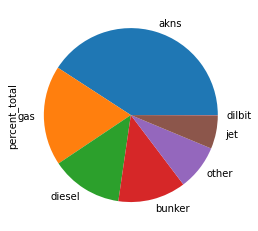

In [20]:
plot_oil_type = oil_type.drop('total')
plot_oil_type['percent_total'].plot.pie()
plot_oil_type['percent_total'].sum()

##### show volumes for "other" oil types

#### by facility

In [21]:
# create dataframe from dictionary
facility_transfers = pd.DataFrame(data=transfers_byloc,index=[0])
facility_volumes = pd.DataFrame(data=volume_byloc,index=[1])
# dataframe with facilities as columns
facility_cols = facility_transfers.append(facility_volumes)
facility_cols.index = ['transfers','volume_gallons']
# dataframe with facilities as rows
facility = facility_cols.transpose().sort_values(by=['volume_gallons'], ascending=False).copy()
facility

,transfers,volume_gallons
BP Cherry Point Refinery,543,3562469570
Shell Puget Sound Refinery,408,1997329772
Andeavor Anacortes Refinery (formerly Tesoro),425,1281986324
Phillips 66 Ferndale Refinery,638,1251999000
SeaPort Sound Terminal,410,381362598
U.S. Oil & Refining,260,291951121
Alon Asphalt Company (Paramount Petroleum),451,288611987
Tidewater Snake River Terminal,244,243723742
Kinder Morgan Liquids Terminal - Harbor Island,369,211122332
Tesoro Pasco Terminal,112,107662726


In [22]:
# Add column for volume in m3 
facility['volume_m3'] = [(gal2m3 * volume) for volume in facility['volume_gallons']]

# Add volume/transfers to dataframe
facility['m3_per_transfer'] = [volume/transfer for volume,transfer in zip(facility['volume_m3'],facility['transfers'])]
facility['percent_total_volume'] = [100*volume/net_volume for volume in facility['volume_m3']]

# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'm3_per_transfer':'{:.2E}', 'percent_total_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    facility[key] = facility[key].apply(value.format)
facility.index.name='LOCATION'
facility.to_excel(output_directory/"facility_transfers.xlsx", sheet_name='facility') 
facility

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total_volume
LOCATION,,,,,
BP Cherry Point Refinery,543,3.56E+09,1.35E+07,2.48E+04,35.65%
Shell Puget Sound Refinery,408,2.00E+09,7.56E+06,1.85E+04,19.99%
Andeavor Anacortes Refinery (formerly Tesoro),425,1.28E+09,4.85E+06,1.14E+04,12.83%
Phillips 66 Ferndale Refinery,638,1.25E+09,4.74E+06,7.43E+03,12.53%
SeaPort Sound Terminal,410,3.81E+08,1.44E+06,3.52E+03,3.82%
U.S. Oil & Refining,260,2.92E+08,1.11E+06,4.25E+03,2.92%
Alon Asphalt Company (Paramount Petroleum),451,2.89E+08,1.09E+06,2.42E+03,2.89%
Tidewater Snake River Terminal,244,2.44E+08,9.23E+05,3.78E+03,2.44%
Kinder Morgan Liquids Terminal - Harbor Island,369,2.11E+08,7.99E+05,2.17E+03,2.11%


### for other oil types

In [23]:
# create dataframe from dictionary
other_transfers = pd.DataFrame(data=other)
other_transfers['percent_other_volume'] = [100*volume/other_transfers['volume_m3'].sum() for volume in other_transfers['volume_m3']]
other_transfers['percent_all_volume'] = [100*volume/net_volume for volume in other_transfers['volume_m3']]
other_transfers.sort_values(by=['volume_m3'],ascending=False)
other_transfers.to_excel(output_directory/"other_transfers.xlsx", sheet_name='other_oiltype')
# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'percent_other_volume':'{:.2f}%',  'percent_all_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    other_transfers[key] = other_transfers[key].apply(value.format)
other_transfers.set_index('types')

,volume_gallons,transfers,volume_m3,percent_other_volume,percent_all_volume
types,,,,,
Cat Feed/VGO,4.44E+08,119,1.68E+06,52.31%,4.44%
ETHANOL,1.05E+08,83,3.99E+05,12.42%,1.05%
CUTTER STOCK,7.90E+07,107,2.99E+05,9.31%,0.79%
OILY WASTE,9.30E+06,16,3.52E+04,1.10%,0.09%
WASTE OIL,1.24E+06,10,4.70E+03,0.15%,0.01%
NAPTHA,6.72E+07,16,2.55E+05,7.93%,0.67%
Z-OTHER,6.43E+07,62,2.43E+05,7.58%,0.64%
EDIBLE/VEGETABLE OIL,1.78E+07,4,6.74E+04,2.10%,0.18%
DECANT OIL,4.90E+07,31,1.86E+05,5.78%,0.49%


### Voyage data includes both cargo and fueling transfers

In [24]:
transfers_byloc_wfuel = {}
volume_byloc_wfuel = {}

for loc in facility_names:
    transfers_byloc_wfuel[loc] = 0
    volume_byloc_wfuel[loc] = 0

for row in range(nrows):
    
    # ~~~~~~~ COMBINED IMPORTS AND EXPORTS, FUEL AND CARGO ~~~~~~~
    if (DOE_df.Receiver[row] in facility_names or
        DOE_df.Deliverer[row] in facility_names
       ):
        
         # ~~~~~~ Tally transfers by terminal ~~~~~~~~~~~  
        if (DOE_df.Receiver[row] in facility_names):
            transfers_byloc_wfuel[DOE_df.Receiver[row]] += 1
            volume_byloc_wfuel[DOE_df.Receiver[row]] += DOE_df.TransferQtyInGallon[row]
        elif (DOE_df.Deliverer[row] in facility_names):
            transfers_byloc_wfuel[DOE_df.Deliverer[row]] += 1
            volume_byloc_wfuel[DOE_df.Deliverer[row]] += DOE_df.TransferQtyInGallon[row]
            
            
# create dataframe from dictionary
facility_transfers = pd.DataFrame(
    data=transfers_byloc_wfuel,
    index=[0]
)
facility_volumes = pd.DataFrame(
    data=volume_byloc_wfuel,
    index=[1]
)
# dataframe with facilities as columns
facility_cols = facility_transfers.append(facility_volumes)
facility_cols.index = ['transfers','volume_gallons']

# dataframe with facilities as rows
facility_wfuel = facility_cols.transpose().sort_values(by=['transfers'], ascending=False).copy()
# Add volume in m3
facility_wfuel['volume_m3'] = [(gal2m3 * volume) for volume in facility_wfuel['volume_gallons']]
# Add volume/transfers to dataframe
facility_wfuel['m3_per_transfer'] = [volume/transfer for volume,transfer in zip(facility_wfuel['volume_m3'],facility_wfuel['transfers'])]
facility_wfuel['percent_total_volume'] = [100*volume/net_volume for volume in facility_wfuel['volume_m3']]
facility_wfuel.index.name = 'LOCATION'
facility_wfuel

,transfers,volume_gallons,volume_m3,m3_per_transfer,percent_total_volume
LOCATION,,,,,
Kinder Morgan Liquids Terminal - Harbor Island,3021,251772054,9.530605e+05,315.478468,2.519737
Phillips 66 Ferndale Refinery,639,1252545000,4.741396e+06,7420.025616,12.535484
BP Cherry Point Refinery,543,3562469570,1.348541e+07,24835.005405,35.653234
Alon Asphalt Company (Paramount Petroleum),459,294087892,1.113243e+06,2425.366552,2.943235
SeaPort Sound Terminal,450,386426941,1.462784e+06,3250.632015,3.867365
Tidewater Snake River Terminal,445,247509050,9.369232e+05,2105.445467,2.477073
Andeavor Anacortes Refinery (formerly Tesoro),425,1281986324,4.852844e+06,11418.456119,12.830133
Shell Puget Sound Refinery,408,1997329772,7.560712e+06,18531.157089,19.989298
U.S. Oil & Refining,366,295630195,1.119081e+06,3057.599717,2.958670


In [25]:
# format output
format_mapping={'transfers':'{:,.0f}', 'volume_gallons':'{:.2E}', 'volume_m3':'{:.2E}', 'm3_per_transfer':'{:.2E}', 'percent_total_volume':'{:.2f}%'}
for key, value in format_mapping.items():
    facility_wfuel[key] = facility_wfuel[key].apply(value.format)

facility_wfuel.to_excel(output_directory/"facility_transfers_wfuel.xlsx", sheet_name='facility_wfuel') 


### Load Cam's data on number of voyages linked to WA marine terminals

In [26]:
camdf_tankers = pd.read_excel(
    CamSheet,
    sheet_name="VoyageCountsbyFacility_MR", 
    usecols="M,N,O",
    skiprows = 1
)
camdf_barges = pd.read_excel(
    CamSheet,
    sheet_name="VoyageCountsbyFacility_MR", 
    usecols="E,F,G,J",
    skiprows = 1
)

In [27]:
camdf_tankers=camdf_tankers.rename(
    columns={"LOCATION.3":"LOCATION", "TRANSFERS.3":"Voyage_transfers", 
             "FACILITY CATEGORY.3":"CATEGORY"}
)
camdf_barges=camdf_barges.rename(
    columns={"LOCATION.1":"LOCATION", "TRANSFERS.1":"atb_transfers", 
             "FACILITY CATEGORY.1":"CATEGORY", "TRANSFERS.2":"barge_transfers"}
)
# combine barge and atb transfers
camdf_barges['Voyage_transfers'] = camdf_barges['atb_transfers'] + camdf_barges['barge_transfers']

cam_WA={}

#tankers
cam_WA['tankers'] = camdf_tankers.loc[
    camdf_tankers.CATEGORY=='WA',
]
cam_WA['tankers'] = cam_WA['tankers'].set_index("LOCATION")
cam_WA['tankers'] = cam_WA['tankers'].drop(columns="CATEGORY")

#barges
cam_WA['barges'] = camdf_barges.loc[
    camdf_barges.CATEGORY=='WA',
]
cam_WA['barges'] = cam_WA['barges'].set_index("LOCATION")
cam_WA['barges'] = cam_WA['barges'].drop(columns="CATEGORY")

# rename Marathon Anacortes Refinery (formerly Tesoro) to the DOE name
cam_WA['tankers'].rename(
    index={'Marathon Anacortes Refinery (formerly Tesoro)':'Andeavor Anacortes Refinery (formerly Tesoro)'},
    inplace=True
)
cam_WA['barges'].rename(
    index={'Marathon Anacortes Refinery (formerly Tesoro)':'Andeavor Anacortes Refinery (formerly Tesoro)'},
    inplace=True
)
cam_WA['tankers']

,Voyage_transfers
LOCATION,
Alon Asphalt Company (Paramount Petroleum),2.0
BP Cherry Point Refinery,447.0
Kinder Morgan Liquids Terminal - Harbor Island,110.0
Andeavor Anacortes Refinery (formerly Tesoro),221.0
Naval Air Station Whidbey Island (NASWI),0.0
NAVSUP Manchester,3.0
Nustar Energy Vancouver,0.0
Phillips 66 Ferndale Refinery,94.0
Phillips 66 Tacoma Terminal,0.0


---
## Barge attribution of oil cargo vessels
---
#### DOE transfer information
- atb fueling count: 64, cargo transfer count: 471, cargo to fuel ratio: 7.36
- barge fueling count: 228, cargo transfer count: 2026, cargo to fuel ratio: 8.89
- tanker fueling count: 232, cargo transfer count: 503, cargo to fuel ratio: 2.17 

### Evaluate fuel to cargo transfer ratio for ATB/ITBs

In [28]:
DOE_fuel = {}
DOE_cargo = {}

# all fuel transfers in 2018 record
DOE_fuel['atb'] = DOE_df.loc[
    (DOE_df.TransferType == 'Fueling') &
    (DOE_df.Receiver.str.contains('ITB') | 
     DOE_df.Receiver.str.contains('ATB')),
    ['TransferType']
].count().item()
DOE_fuel['barge'] = DOE_df.loc[
    (DOE_df.TransferType == 'Fueling') &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Receiver.str.contains('ITB')) & 
    (~DOE_df.Receiver.str.contains('ATB')),
    ['TransferType']
].count().item()
DOE_fuel['tanker'] = DOE_df.loc[
    (DOE_df.TransferType == 'Fueling') &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP'),
    ['TransferType']
].count().item()

# all cargo transfers in 2018 record
DOE_cargo['atb'] = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.Receiver.str.contains('ITB') | 
     DOE_df.Receiver.str.contains('ATB')),
    ['TransferType']
].count().item()
DOE_cargo['barge'] = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Receiver.str.contains('ITB')) & 
    (~DOE_df.Receiver.str.contains('ATB')),
    ['TransferType']
].count().item()
DOE_cargo['tanker'] = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP'),
    ['TransferType']
].count().item()

In [29]:
for vessel_type in ['atb','barge','tanker']:
    print(
        f'{vessel_type} fueling count: {DOE_fuel[vessel_type]}, cargo transfer count: {DOE_cargo[vessel_type]}, cargo to fuel ratio: {DOE_cargo[vessel_type]/(DOE_fuel[vessel_type]):.2f}')

atb fueling count: 64, cargo transfer count: 471, cargo to fuel ratio: 7.36
barge fueling count: 228, cargo transfer count: 2026, cargo to fuel ratio: 8.89
tanker fueling count: 232, cargo transfer count: 503, cargo to fuel ratio: 2.17


### Add up number of unique vessels identified as ATB or ITB in DOE database

In [30]:
doe_atb_out = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.Receiver.str.contains('ITB') | 
     DOE_df.Receiver.str.contains('ATB')),
    ['Receiver','Deliverer']
].groupby('Receiver').count()
len(doe_atb_out)

17

In [31]:
doe_atb_in = DOE_df.loc[
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.Deliverer.str.contains('ITB') | 
     DOE_df.Deliverer.str.contains('ATB')),
    ['Receiver','Deliverer']
].groupby('Deliverer').count()
len(doe_atb_in)

13

In [32]:
# make sure doe_atb_out is a complete list of ATB names 
print('*** ATBs delivering cargo that are not in list of cargo receivers ***')
for atb in doe_atb_in.index.values.tolist():
    if atb not in doe_atb_out.index.values.tolist():
        print(atb)
print('*** ATBs that received oil as cargo ***')
print(doe_atb_out)

*** ATBs delivering cargo that are not in list of cargo receivers ***
ATB TUG ISLAND MONARCH
ITB ISLAND TRADER
*** ATBs that received oil as cargo ***
                                 Deliverer
Receiver                                  
ATB BARGE 550-2                         79
ATB BARGE 550-3                          9
ATB BARGE 650-10                        51
ATB BARGE 650-2                          8
ATB BARGE 650-7                         11
ATB BARGE ALL ABOARD FOR A CURE         40
ATB BARGE DBL 185                       94
ATB BARGE DBL 78                         1
ATB BARGE DBL185                         2
ATB BARGE DR. ROBERT J. BEALL            6
ATB BARGE EDWARD ITTA                    4
ATB BARGE FIGHT FANCONI ANEMIA          43
ATB BARGE KIRBY 185-01                  17
ATB BARGE ONEDREAM                      56
ATB BARGE ZIDELL MARINE 277             39
ITB SUPPLIER                             9
ITB VANCOUVER                            2


### DOE transfers sorted by:
- Selecting **tanker cargo** transfers in DOE data
- Selecting **tanker cargo & fuel** transfers in DOE data
- Selecting **barge, atb and barge/atb combined cargo** transfers in DOE data
- Selecting **barge, atb and barge/atb combined cargo & fuel** transfers in DOE data

In [33]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## tankers
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
DOE_tanker_in = {}
DOE_tanker_out = {}

DOE_tanker_in['cargo'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.DelivererTypeDescription == 'TANK SHIP' ),
].groupby('Receiver').count()

DOE_tanker_in['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.DelivererTypeDescription == 'TANK SHIP' ),
].groupby('Receiver').count()

DOE_tanker_out['cargo'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('Deliverer').count()

DOE_tanker_out['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('Deliverer').count()

# prepare columns for merging with monte carlo transfers
for transfer_type in ['cargo','cargo_fuel']:
    DOE_tanker_in[transfer_type]=DOE_tanker_in[transfer_type].rename(
        columns={"Deliverer":"transfers"}
    )
    DOE_tanker_out[transfer_type]=DOE_tanker_out[transfer_type].rename(
        columns={"Receiver":"transfers"}
    )
    
    DOE_tanker_in[transfer_type]=DOE_tanker_in[transfer_type].drop(
        columns=[
            "Product","TransferQtyInGallon","TransferType",
            "DelivererTypeDescription","ReceiverTypeDescription"
        ]
    )
    DOE_tanker_out[transfer_type]=DOE_tanker_out[transfer_type].drop(
        columns=[
            "Product","TransferQtyInGallon","TransferType",
            "DelivererTypeDescription","ReceiverTypeDescription"
        ]
    )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## barges 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
DOE_barge_in = {}
DOE_barge_out = {}

#~~~~~~~~~~~~~~~~~~~~~~~~
# barges: including ATBs
#~~~~~~~~~~~~~~~~~~~~~~~~
DOE_barge_in['all'] = {}
DOE_barge_out['all'] = {}

# ~~~ imports ~~~~~~
DOE_barge_in['all']['cargo'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])),
].groupby('Receiver').count()
DOE_barge_in['all']['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])),
].groupby('Receiver').count() # this ought to be same as 'cargo'

# ~~~ exports ~~~~~
DOE_barge_out['all']['cargo'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])),
].groupby('Deliverer').count()
DOE_barge_out['all']['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])),
].groupby('Deliverer').count()
#~~~~~~~~~~~~~~~~~~~~~
# barges: ATB - only
#~~~~~~~~~~~~~~~~~~~~~
DOE_barge_in['atb'] = {}
DOE_barge_out['atb'] = {}

# ~~~ imports ~~~~~~
DOE_barge_in['atb']['cargo'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &  
    (DOE_df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (DOE_df.Deliverer.str.contains('ITB') | 
     DOE_df.Deliverer.str.contains('ATB')),
].groupby('Receiver').count()
DOE_barge_in['atb']['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (DOE_df.Deliverer.str.contains('ITB') | 
     DOE_df.Deliverer.str.contains('ATB')),
].groupby('Receiver').count() # this ought to be same as 'cargo'

# ~~~ exports ~~~~~
DOE_barge_out['atb']['cargo'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (DOE_df.Receiver.str.contains('ITB') | 
     DOE_df.Receiver.str.contains('ATB')),
].groupby('Deliverer').count()
DOE_barge_out['atb']['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (DOE_df.Receiver.str.contains('ITB') | 
     DOE_df.Receiver.str.contains('ATB')),
].groupby('Deliverer').count()

#~~~~~~~~~~~~~~~~~~~~~
# barges: barge - only
#~~~~~~~~~~~~~~~~~~~~~

DOE_barge_in['barge'] = {}
DOE_barge_out['barge'] = {}

# ~~~ imports ~~~~~~
DOE_barge_in['barge']['cargo'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &  
    (DOE_df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Deliverer.str.contains('ITB')) & 
    (~DOE_df.Deliverer.str.contains('ATB')),
].groupby('Receiver').count()
DOE_barge_in['barge']['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Deliverer.str.contains('ITB')) & 
    (~DOE_df.Deliverer.str.contains('ATB')),
].groupby('Receiver').count() # this ought to be same as 'cargo'

# tally oil types 
DOE_barge_in['barge']['cargo_oil'] = DOE_df.loc[
    (DOE_df.Receiver.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &  
    (DOE_df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Deliverer.str.contains('ITB')) & 
    (~DOE_df.Deliverer.str.contains('ATB')),
    ['Product','Receiver']
].groupby('Product').count()

# ~~~ exports ~~~~~
DOE_barge_out['barge']['cargo'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Receiver.str.contains('ITB')) & 
    (~DOE_df.Receiver.str.contains('ATB')),
].groupby('Deliverer').count()
DOE_barge_out['barge']['cargo_fuel'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Receiver.str.contains('ITB')) & 
    (~DOE_df.Receiver.str.contains('ATB')),
].groupby('Deliverer').count()
# tally oil types 
DOE_barge_out['barge']['cargo_oil'] = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.TransferType == 'Cargo') &  
    (DOE_df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
    (~DOE_df.Receiver.str.contains('ITB')) & 
    (~DOE_df.Receiver.str.contains('ATB')),
    ['Product','Receiver']
].groupby('Product').count()

for grouping in ['all','atb','barge']:  
    for transfer_type in ['cargo','cargo_fuel']:
        # prepare columns for merging with monte carlo transfers
        DOE_barge_in[grouping][transfer_type]=(
            DOE_barge_in[grouping][transfer_type].rename(
                columns={"Deliverer":"transfers"}
            )
        )
        DOE_barge_out[grouping][transfer_type]=(
            DOE_barge_out[grouping][transfer_type].rename(
                columns={"Receiver":"transfers"}
            )   
        )
        # clean up lists by removing unneccessary columns
        DOE_barge_in[grouping][transfer_type]=(
            DOE_barge_in[grouping][transfer_type].drop(
                columns=[
                    "Product","TransferQtyInGallon","TransferType",
                    "DelivererTypeDescription","ReceiverTypeDescription"
                ]
            )
        )
        DOE_barge_out[grouping][transfer_type]=(
            DOE_barge_out[grouping][transfer_type].drop(
                columns=[
                    "Product","TransferQtyInGallon","TransferType",
                    "DelivererTypeDescription","ReceiverTypeDescription"
                ]
            )
        )


### Show oil allocation for barges

In [34]:
oil_types = DOE_barge_in['barge']['cargo_oil'].index.values.tolist()
for oil in DOE_barge_out['barge']['cargo_oil'].index.values.tolist():
    if oil not in oil_types:
        oil_types.append(oil)

# NEXT: loop through DOE_barge_in['barge']['cargo_oil'] and add Receiver entries to those from DOE_barge_out['barge']['cargo_oil'] to get net transfers

In [35]:
DOE_barge_in['barge']['cargo_oil']

,Receiver
Product,
BAKKEN,1
BIODIESEL,4
BUNKER OIL/HFO,226
CRUDE OIL,8
CUTTER STOCK,30
Cat Feed/VGO,7
DECANT OIL,8
DIESEL LOW SULPHUR (ULSD),134
DIESEL/MARINE GAS OIL,62


In [36]:
# DOE_barge_oil = pd.DataFrame(oil_types)
# for oil in oil_types:
    
# DOE_barge_oil

<ipython-input-37-ee41dae2ec7a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DOE_barge_in['barge']['cargo_oil']['Product'][row] = 'OTHER'


Text(0.5, 1.0, 'DOE oil cargo transfers for non-ATB barge traffic')

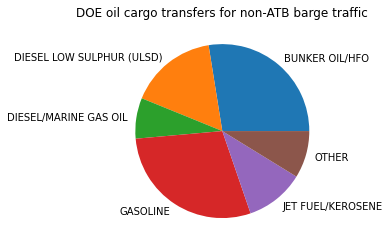

In [37]:
DOE_barge_in['barge']['cargo_oil'].reset_index(inplace=True)
for row,value in enumerate(DOE_barge_in['barge']['cargo_oil']['Product']):
    if DOE_barge_in['barge']['cargo_oil']['Receiver'][row] < 50: 
        DOE_barge_in['barge']['cargo_oil']['Product'][row] = 'OTHER' 
ax = DOE_barge_in['barge']['cargo_oil'].groupby('Product').sum('Receiver').plot.pie(y='Receiver',legend=None) 
ax.set_ylabel('')
ax.set_title('DOE oil cargo transfers for non-ATB barge traffic')


### Create dataframe for transfers

In [38]:
# Combine imports and exports
DOE_tanker = pd.DataFrame(facility_names)
DOE_tanker = DOE_tanker.set_index([0])
DOE_barges = {}
for grouping in ['all','atb','barge']:
    DOE_barges[grouping] = pd.DataFrame(facility_names)
    DOE_barges[grouping] = DOE_barges[grouping].set_index([0])

#### Add cargo-only transfers to dataframe

In [39]:
# add imports/exports for tanker traffic
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_in['cargo'], 
    left_index = True,
    right_index=True,
    how='left'
)
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_out['cargo'], 
    left_index = True,
    right_index=True,
    how='left'
)
#combine import/export (transfers_x/transfers_y) and clean up DOE_df
DOE_tanker['DOE_transfers(cargo)'] = (
    DOE_tanker.transfers_x.fillna(0) + DOE_tanker.transfers_y.fillna(0)
)

# clean up by clipping transfers_x, _y
DOE_tanker=DOE_tanker.drop(
    columns={'transfers_x','transfers_y'}
)

# add imports/exports for barge traffic
for grouping in ['all','atb','barge']:
    DOE_barges[grouping] = pd.merge(
        left=DOE_barges[grouping], 
        right=DOE_barge_in[grouping]['cargo'], 
        left_index = True,
        right_index=True,
        how='left'
    )
    DOE_barges[grouping] = pd.merge(
        left=DOE_barges[grouping], 
        right=DOE_barge_out[grouping]['cargo'], 
        left_index = True,
        right_index=True,
        how='left'
    )
    #combine import/export (transfers_x/transfers_y) and clean up DOE_df
    DOE_barges[grouping]['DOE_transfers(cargo)'] = (
        DOE_barges[grouping].transfers_x.fillna(0) + \
        DOE_barges[grouping].transfers_y.fillna(0)
    )
    # clean up by clipping transfers_x, _y
    DOE_barges[grouping]=DOE_barges[grouping].drop(
        columns={'transfers_x','transfers_y'}
    )

#### Add combined cargo and fuel transfers 

In [40]:
# now repeat for cargo + fuel transfers
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_in['cargo_fuel'], 
    left_index = True,
    right_index=True,
    how='left'
)
DOE_tanker = pd.merge(
    left=DOE_tanker, 
    right=DOE_tanker_out['cargo_fuel'], 
    left_index = True,
    right_index=True,
    how='left'
)
DOE_tanker['DOE_transfers(cargo+fuel)'] = (
    DOE_tanker.transfers_x.fillna(0) + DOE_tanker.transfers_y.fillna(0)
)
DOE_tanker=DOE_tanker.drop(columns={'transfers_x','transfers_y'})


for grouping in ['all','atb','barge']:
    DOE_barges[grouping] = pd.merge(
        left=DOE_barges[grouping], 
        right=DOE_barge_in[grouping]['cargo_fuel'], 
        left_index = True,
        right_index=True,
        how='left'
    )

    DOE_barges[grouping] = pd.merge(
        left=DOE_barges[grouping], 
        right=DOE_barge_out[grouping]['cargo_fuel'], 
        left_index = True,
        right_index=True,
        how='left'
    )
    #combine import/export (transfers_x/transfers_y) and clean up DOE_df
    DOE_barges[grouping]['DOE_transfers(cargo+fuel)'] = (
        DOE_barges[grouping].transfers_x.fillna(0) + \
        DOE_barges[grouping].transfers_y.fillna(0)
    )
    # clean up by clipping transfers_x, _y
    DOE_barges[grouping]=DOE_barges[grouping].drop(
        columns={'transfers_x','transfers_y'}
    )

### Evaluate barge transfers by comparing:
- voyages dataset, 10,000 monte-carlo spills and DOE transfers for ATB, barges and combined.  Voyages information is in camdf_barges['atb_transfers'], camdf_barges['barge_transfers'] and camdf_barges['Voyages_transfers'] for atb, barges and all categories, respectively 

## Volume exports by TransferType (Cargo, Fueling, etc) for:
1. Marine terminals included in this study
2. All marine terminals in DOE database

In [41]:
# fuel and cargotransfers from ONLY marine terminals in our study
DOE_tanker_out_all = DOE_df.loc[
    (DOE_df.Deliverer.isin(facility_names)) &
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('TransferType').count()
DOE_tanker_out_all

,Deliverer,Receiver,Product,TransferQtyInGallon,DelivererTypeDescription,ReceiverTypeDescription
TransferType,,,,,,
Cargo,495,495,495,495,495,495
Fueling,3,3,3,3,3,3
Other (incl Lube/Hyd Oil),4,4,4,4,4,4


In [42]:
# fuel and cargotransfers from all marine terminals
DOE_tanker_out_all = DOE_df.loc[
    (DOE_df.ReceiverTypeDescription == 'TANK SHIP' ),
].groupby('TransferType').sum()
DOE_tanker_out_all

,TransferQtyInGallon
TransferType,
Cargo,1895755949
Fueling,53195038
Lightering,1890000
Other (incl Lube/Hyd Oil),809181
Vacuum,504


### TAKE AWAY: I don't get "the why" but it appears that tanker ships don't fuel up at the WA marine terminals listed in our study and that "cargo-only" transfers are fairly representative of ALL transfers to tank ships from US marine terminals included in our study

### Add DOE transfer data to the Cam_WA dataframe

In [43]:
cam_WA['tankers'] = pd.merge(
    left=cam_WA['tankers'], 
    right=DOE_tanker, 
    left_index = True,
    right_index=True,
    how='left'
)
for grouping in ['atb','barge','all']:
    cam_WA['barges'] = pd.merge(
        left=cam_WA['barges'], 
        right=DOE_barges[grouping], 
        left_index = True,
        right_index=True,
        how='left'
    )
    cam_WA['barges']=cam_WA['barges'].rename(
        columns={"DOE_transfers(cargo)":f"DOE_{grouping}_transfers"}
    )
    cam_WA['barges']=cam_WA['barges'].drop(columns={"DOE_transfers(cargo+fuel)"})
cam_WA['barges'].head(1)

,atb_transfers,barge_transfers,Voyage_transfers,DOE_atb_transfers,DOE_barge_transfers,DOE_all_transfers
LOCATION,,,,,,
Alon Asphalt Company (Paramount Petroleum),0.0,559.0,559.0,0.0,446.0,446.0


---
# Barge assessment: Add monte carlo transfers from 10,000 spill file
---

In [44]:
monte_df = pd.read_csv(monte_carlo_csv)

## Evaluate:
- total number of barge spills 
- total number of barge fuel spills
- total number of barge cargo spills

In [45]:
mc_barge = monte_df.loc[
    monte_df.vessel_type=='barge',
]
mc_barge_spilltype = mc_barge.groupby('fuel_cargo').count().spill_date_hour
mc_barge_cargo = mc_barge_spilltype[0]
mc_barge_fuel = mc_barge_spilltype[1]
mc_barge_total = len(mc_barge)
print('----- Barge spills -------')
print(f'Fuel: {mc_barge_fuel}, {100*mc_barge_fuel/mc_barge_total:.2f}%')
print(f'Cargo: {mc_barge_cargo}, {100*mc_barge_cargo/mc_barge_total:.2f}%')
print(f'Total: {mc_barge_total}')

----- Barge spills -------
Fuel: 3080, 83.49%
Cargo: 609, 16.51%
Total: 3689


### Count spills with origin/destination information

In [77]:
total_voyage_spills = {}

In [47]:
origin = mc_barge.groupby('vessel_origin').count()
dest   = mc_barge.groupby('vessel_dest').count()
origin_dest = data =origin['vessel_dest'].add(dest['vessel_origin'], fill_value = 0)

Text(0.5, 1.0, 'Total number of records = 4404 out of 10,000')

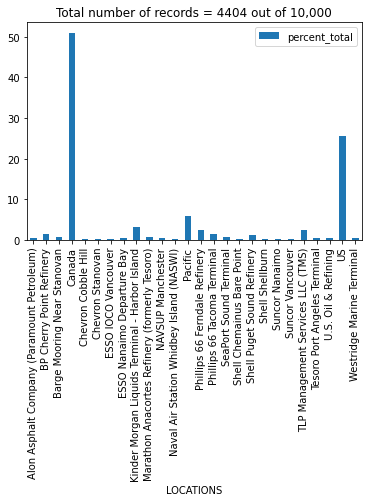

In [48]:
mc_barge_attr = pd.DataFrame(origin_dest)
mc_barge_attr = mc_barge_attr.rename(columns={0:'transfer_count'})
mc_barge_attr.index.name='LOCATIONS'
mc_barge_attr['percent_total'] = 100*mc_barge_attr['transfer_count']/mc_barge_attr['transfer_count'].sum()

mc_barge_attr['percent_total'].plot.bar
ax = mc_barge_attr.plot.bar(y='percent_total')
total_voyage_spills['barge'] = mc_barge_attr['transfer_count'].sum()
ax.set_title(f'Total number of records = {total} out of 10,000')

## Evaluate fuel-to-cargo spills for:
- No origin/destination tracks
- Generic origin/destination
- marine terminal attribution 

In [79]:
fuel_to_cargo={}
fuel_to_cargo['barge']={}

In [102]:
mc_barge[mc_barge.vessel_origin.isna() & mc_barge.vessel_dest.isna()].shape[0]

1487

In [141]:
# no origin/destination
fuel_to_cargo['barge']['NaN'] = mc_barge[
    mc_barge.vessel_origin.isna() &
    mc_barge.vessel_dest.isna()
]
# generic 
fuel_to_cargo['barge']['generic'] = mc_barge[
    mc_barge.vessel_origin.isin(['US','Canada','Pacific']) &
    mc_barge.vessel_dest.isin(['US','Canada','Pacific'])
]
# marine terminals 
fuel_to_cargo['barge']['terminals'] = mc_barge[
    (~mc_barge.vessel_origin.isna()) &
    (~mc_barge.vessel_dest.isna()) &
    (~mc_barge.vessel_origin.isin(['US','Canada','Pacific'])) &
    (~mc_barge.vessel_dest.isin(['US','Canada','Pacific']))
]

fuel_to_cargo['barge']['one_terminal'] = mc_barge[
    (mc_barge.vessel_origin.isin(facility_names_mc) |
     mc_barge.vessel_dest.isin(facility_names_mc))
]

total_same = fuel_to_cargo['barge']['terminals'][
    fuel_to_cargo['barge']['terminals']['vessel_origin'] == fuel_to_cargo['barge']['terminals']['vessel_dest']
].shape[0]

In [142]:
# print results 
total = 0
print('*** Number of barge transfers within voyage category ***')
print(fuel_to_cargo['barge']['NaN'].shape[0],': NaN (origin & destination)')
print(fuel_to_cargo['barge']['generic'].shape[0],': US, Pacific, Canada (origin & destination)')
print(fuel_to_cargo['barge']['terminals'].shape[0],': marine terminals (origin & destination)')
for attr in ['NaN','generic','terminals']:
    total+=fuel_to_cargo['barge'][attr].shape[0]
print('-----------------------')
print(f'{total} : Sum of the first three')

print('-----------------------')
print(fuel_to_cargo['barge']['one_terminal'].shape[0],': US marine terminals (origin _or_ destination)')



*** Number of barge transfers within voyage category ***
1487 : NaN (origin & destination)
1592 : US, Pacific, Canada (origin & destination)
162 : marine terminals (origin & destination)
-----------------------
3241 : Sum of the first three
-----------------------
539 : US marine terminals (origin _or_ destination)


In [126]:
print('*** Number of transfers to/from terminals with same origin as destination ***')
print(fuel_to_cargo['barge']['terminals'][
    fuel_to_cargo['barge']['terminals']['vessel_origin'] == fuel_to_cargo['barge']['terminals']['vessel_dest']
].shape[0])

*** Number of transfers to/from terminals with same origin as destination ***
24


In [135]:
fuel_to_cargo['barge']['NaN'].groupby('fuel_cargo').count().spill_date_hour

fuel_cargo
cargo      78
fuel     1409
Name: spill_date_hour, dtype: int64

### fuel-to-cargo spill ratio for each voyage type

In [148]:
fuel_to_cargo['barge']['percent_cargo_spill']={}
print('*** Percent of spills that are cargo spills ***')
for attr in ['NaN','generic','terminals']:    
    fuel_to_cargo['barge']['percent_cargo_spill'][attr] = (
        100*fuel_to_cargo['barge'][attr].groupby('fuel_cargo').count().spill_date_hour[0]/
        (fuel_to_cargo['barge'][attr].groupby('fuel_cargo').count().spill_date_hour[0]+
         fuel_to_cargo['barge'][attr].groupby('fuel_cargo').count().spill_date_hour[1])
    )
    print(f'{attr}: ', fuel_to_cargo['barge']['percent_cargo_spill'][attr])
print('------------------')

fuel_to_cargo['barge']['percent_cargo_spill']['one_terminal'] = (
        100*fuel_to_cargo['barge']['one_terminal'].groupby('fuel_cargo').count().spill_date_hour[0]/
        (fuel_to_cargo['barge']['one_terminal'].groupby('fuel_cargo').count().spill_date_hour[0]+
         fuel_to_cargo['barge']['one_terminal'].groupby('fuel_cargo').count().spill_date_hour[1])
)
print('origin or destination as US terminal: ', fuel_to_cargo['barge']['percent_cargo_spill']['one_terminal'])

*** Percent of spills that are cargo spills ***
NaN:  5.245460659045057
generic:  4.396984924623116
terminals:  75.92592592592592
------------------
origin or destination as US terminal:  74.95361781076066


## Evaluate: 
- monte-carlo representation of barge transfers to US marine terminals

In [52]:
mc_barge_dest = monte_df.loc[ 
    (monte_df.vessel_dest.isin(facility_names_mc)) &
    (monte_df.vessel_type=='barge'),
    ['vessel_origin','vessel_dest']
].groupby('vessel_dest').count()
mc_barge_origin = monte_df.loc[ 
    (monte_df.vessel_origin.isin(facility_names_mc))&
    (monte_df.vessel_type=='barge'),
    ['vessel_origin','vessel_dest']
].groupby('vessel_origin').count()

# combine count for spills with US marine terminal as origin and dest
mc_barge_both = mc_barge_dest.merge(mc_barge_origin.vessel_dest, left_index=True, right_index=True).sum(axis=1)
# convert series back to dataframe
mc_barge_both = mc_barge_both.reset_index() 
# rename index to merge with Camdf and add a useful col. name
mc_barge_both=mc_barge_both.rename(
    columns={'vessel_dest':'LOCATION',list(mc_barge_both)[1]:'10000_spills'}
)
mc_barge_both=mc_barge_both.set_index('LOCATION')

## Combine and plot transfer dataframes

In [53]:
cam_WA['barges'] = pd.merge(
        left=cam_WA['barges'], 
        right=mc_barge_both, 
        left_index = True,
        right_index=True,
        how='left'
    )

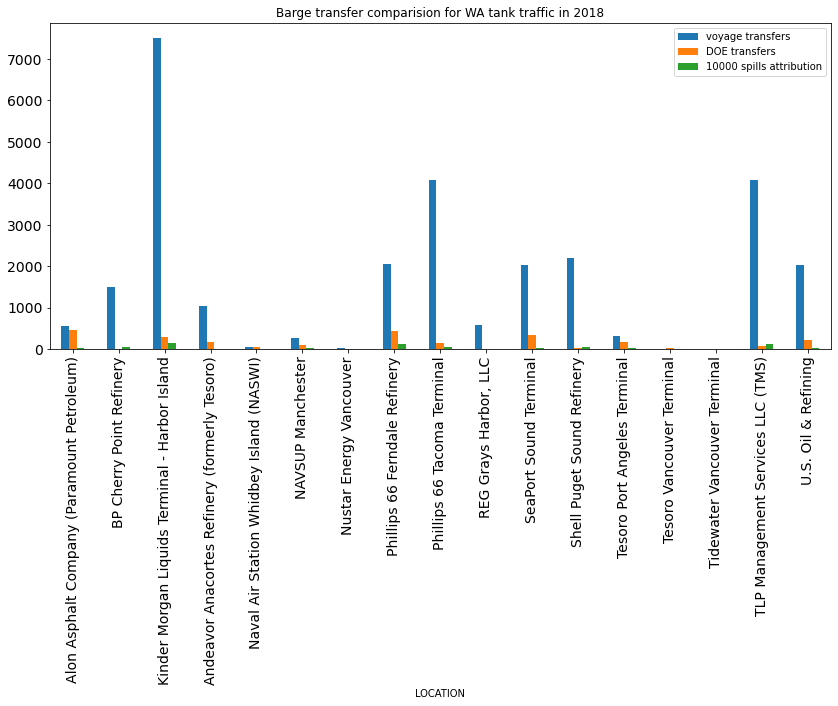

In [54]:
cam_WA['barges'].plot(
    y=['barge_transfers', 'DOE_barge_transfers', '10000_spills'], 
    label=['voyage transfers', 'DOE transfers', '10000 spills attribution'],
    kind = "bar",
    figsize=(14,6),
    fontsize=14
)
plt.title('Barge transfer comparision for WA tank traffic in 2018')
plt.savefig(graphics_directory/'barge_transfers_voyage_DOE_mc.png',bbox_inches='tight')
plt.show()


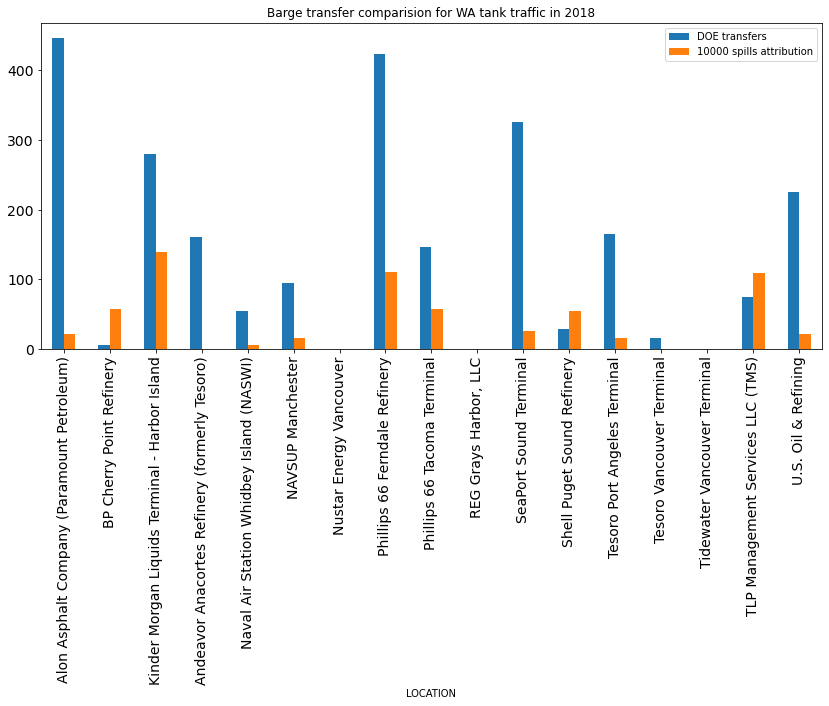

In [55]:
cam_WA['barges'].plot(
    y=['DOE_barge_transfers', '10000_spills'], 
    label=['DOE transfers', '10000 spills attribution'],
    kind = "bar",
    figsize=(14,6),
    fontsize=14
)
plt.title('Barge transfer comparision for WA tank traffic in 2018')
plt.savefig(graphics_directory/'barge_transfers_DOE_mc.png',bbox_inches='tight')
plt.show()

In [56]:
# for merging with DOE and Cam.  Missim Maxum?
monte_df['vessel_dest'] = monte_df['vessel_dest'].replace(
    ['Marathon Anacortes Refinery (formerly Tesoro)'],'Andeavor Anacortes Refinery (formerly Tesoro)'
)
monte_df['vessel_origin'] = monte_df['vessel_origin'].replace(
    ['Marathon Anacortes Refinery (formerly Tesoro)'],'Andeavor Anacortes Refinery (formerly Tesoro)'
)

monte_carlo_transfers = {}
for loc in facility_names:
    monte_carlo_transfers[loc]=len(monte_df[monte_df['vessel_origin']==loc]) + len(monte_df[monte_df['vessel_dest']==loc])
    
monte_carlo_df = pd.DataFrame(
    data=monte_carlo_transfers,
    index=[0]
)
monte_carlo_df.index  = ['monte_carlo_transfers']
monte_carlo_df=monte_carlo_df.transpose().sort_values(by=['monte_carlo_transfers'],ascending=False).copy()
monte_carlo_df.set_index = ['LOCATION']
# # add DOE transfers without fuel
# monte_carlo_df = monte_carlo_df.join(facility['transfers'], how='outer')
# monte_carlo_df.columns = ['monte_carlo_transfers', 'DOE']
# # add DOE transfers with fuel
# monte_carlo_df = monte_carlo_df.join(facility_wfuel.transfers, how='outer')
# # add Cam's voyages
# monte_carlo_df = monte_carlo_df.join(cam_WA['tankers'].Voyage_transfers, how='outer')
# # label columns
# monte_carlo_df.columns = ['monte_carlo_transfers', 'DOE', 'DOE_with_fuel','voyage_transfers']
# monte_carlo_df['DOE'] = monte_carlo_df['DOE'].str.replace(",","").astype(float)
# monte_carlo_df['DOE_with_fuel'] = monte_carlo_df['DOE_with_fuel'].str.replace(",","").astype(float)
monte_carlo_df

,monte_carlo_transfers
Kinder Morgan Liquids Terminal - Harbor Island,152
Phillips 66 Ferndale Refinery,130
TLP Management Services LLC (TMS),115
BP Cherry Point Refinery,93
Shell Puget Sound Refinery,77
Phillips 66 Tacoma Terminal,57
Andeavor Anacortes Refinery (formerly Tesoro),47
SeaPort Sound Terminal,36
U.S. Oil & Refining,25
Alon Asphalt Company (Paramount Petroleum),22


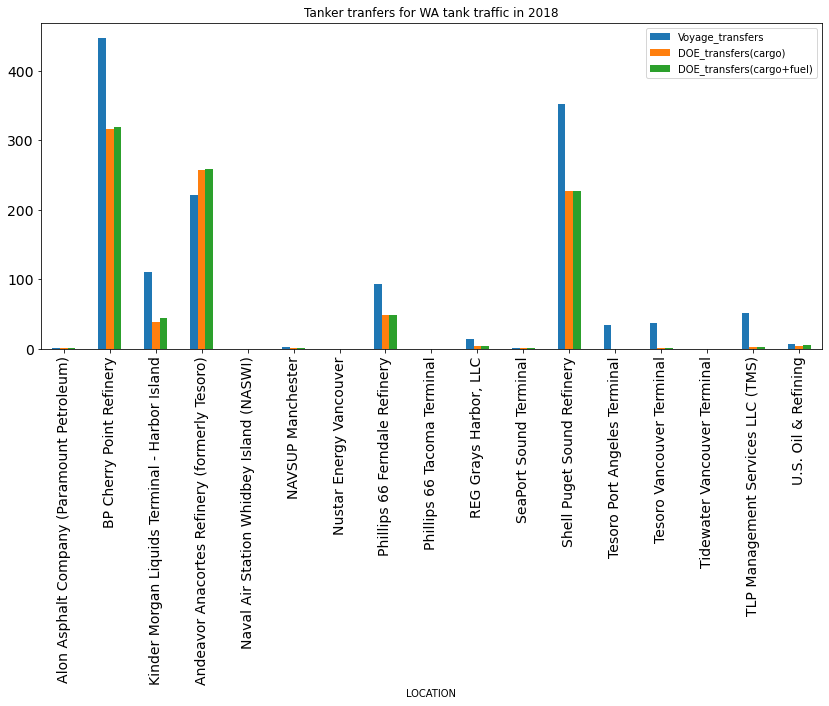

In [57]:
cam_WA['tankers'].plot(y=['Voyage_transfers', 'DOE_transfers(cargo)', 'DOE_transfers(cargo+fuel)'], kind = "bar",figsize=(14,6),fontsize=14)
plt.title('Tanker tranfers for WA tank traffic in 2018')
plt.savefig(graphics_directory/'tanker_transfers_voyage_DOE.png',bbox_inches='tight')
plt.show()

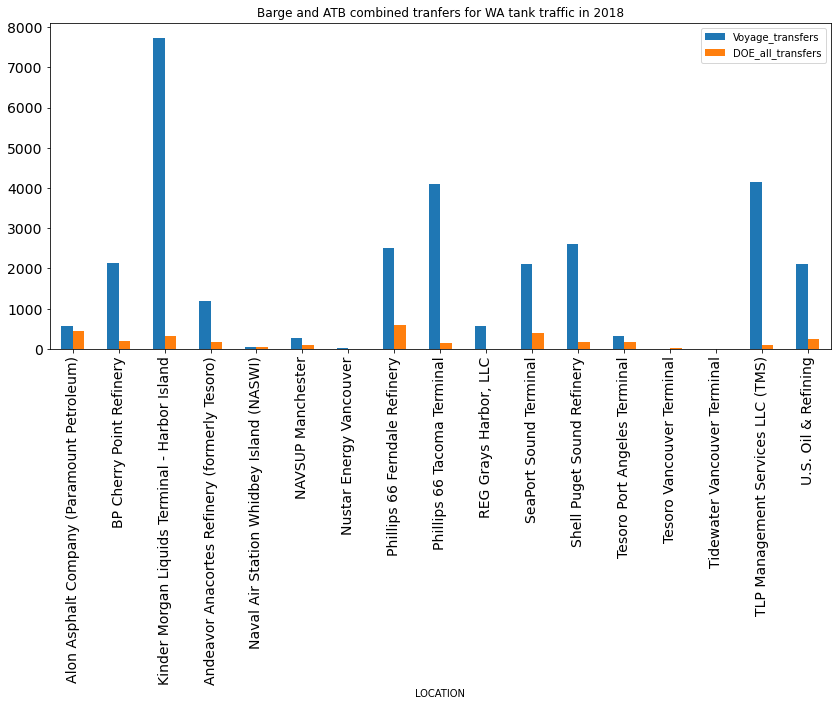

In [58]:
cam_WA['barges'].plot(y=['Voyage_transfers', 'DOE_all_transfers'], kind = "bar",figsize=(14,6),fontsize=14)
plt.title('Barge and ATB combined tranfers for WA tank traffic in 2018')
plt.savefig(graphics_directory/'bargeATB_transfers_voyage_DOE.png',bbox_inches='tight')
plt.show()

The above plot compares the Department of Ecology fuel and cargo transfers for all vessels described as `Tank Barge` or `tugboat` with the ATB and barge vessel tracks in our monte-carlo that are joined in the voyage dataset and attributed to a marine terminal origin or destination (see [Origin_Destination Analysis](https://drive.google.com/file/d/1FUVyeBrSsUjB1jG1lurB6cmBvMxatNMa/view?usp=sharing) in our google drive).  

## TAKE-AWAY: Voyage transfers over predict tank traffic cargo transfers.  Fueling stops for tankers does not explain this difference. One possible explanation is that our method includes ships that are either parked at doc or at close-by moorage awaiting a new job but not engaging in transfers. General pattern looks good for the large transfer sites.

# Group terminals by regions and compare regional transfers
To do this, we need the lat/lon locations for our voyages terminals

In [59]:
FacilitiesSheet = '/Users/rmueller/Library/Mobile Documents/com~apple~CloudDocs/'\
    'Documents/UBC/MIDOSS/Data/Shipping/Origin_Destination_Analysis/' \
    'Oil_Transfer_Facilities.xlsx'

# tankers-only 
facility_locs = pd.read_excel(
    FacilitiesSheet,
    sheet_name="Washington", 
    usecols="B,I,J",
    skiprows = 0
)
facility_locs.head(1)

,FacilityName,DockLatNumber,DockLongNumber
0,BP Cherry Point Refinery,48.86111,-122.758


## Chooose grouping similar to that in `plot_marine_transfers.ipynb` but I remove non-salish terminals 

In [60]:
lat_partition = [47, 48, 48.15, 48.3, 48.7]
transfer_regions = ['non_salish','south','portangeles','naswi','anacortes','north']

non_salish = facility_locs[ facility_locs.DockLatNumber < lat_partition[0] ]
# adjust index to merge with transfer data (same for below)
non_salish = non_salish.rename(columns={"FacilityName":"LOCATIONS"})
non_salish = non_salish.set_index("LOCATIONS")

south  = facility_locs[
    (facility_locs.DockLatNumber > lat_partition[0]) & 
    (facility_locs.DockLatNumber < lat_partition[1])
]
south = south.rename(columns={"FacilityName":"LOCATIONS"})
south = south.set_index("LOCATIONS")

portangeles = facility_locs[
    (facility_locs.DockLatNumber > lat_partition[1]) & 
    (facility_locs.DockLatNumber < lat_partition[2])
]
portangeles = portangeles.rename(columns={"FacilityName":"LOCATIONS"})
portangeles = portangeles.set_index("LOCATIONS")

naswi = facility_locs[
    (facility_locs.DockLatNumber > lat_partition[2]) & 
    (facility_locs.DockLatNumber < lat_partition[3])
]
naswi = naswi.rename(columns={"FacilityName":"LOCATIONS"})
naswi = naswi.set_index("LOCATIONS")

anacortes  = facility_locs[
    (facility_locs.DockLatNumber > lat_partition[3]) & 
    (facility_locs.DockLatNumber < lat_partition[4])
]
anacortes = anacortes.rename(columns={"FacilityName":"LOCATIONS"})
anacortes = anacortes.set_index("LOCATIONS")

north = facility_locs[facility_locs.DockLatNumber > lat_partition[4]]
north = north.rename(columns={"FacilityName":"LOCATIONS"})
north = north.set_index("LOCATIONS")

In [61]:
# did I get them all? 
print(f'{len(non_salish) + len(north) + len(south) + len(anacortes) + len(naswi) + len(portangeles)} vs {len(facility_locs)}')

22 vs 22


### Create dataframes with transfers summed by region

In [62]:
non_salish.head()

,DockLatNumber,DockLongNumber
LOCATIONS,,
Tidewater Snake River Terminal,46.22312,-119.014
Tesoro Vancouver Terminal,45.63551,-122.703
Nustar Energy Vancouver,45.63458,-122.702
Tesoro Pasco Terminal,46.21442,-119.027
"REG Grays Harbor, LLC",46.96580,-123.857


In [63]:
cam_WA['barges'].index

Index(['Alon Asphalt Company (Paramount Petroleum)',
       'BP Cherry Point Refinery',
       'Kinder Morgan Liquids Terminal - Harbor Island',
       'Andeavor Anacortes Refinery (formerly Tesoro)',
       'Naval Air Station Whidbey Island (NASWI)', 'NAVSUP Manchester',
       'Nustar Energy Vancouver', 'Phillips 66 Ferndale Refinery',
       'Phillips 66 Tacoma Terminal', 'REG Grays Harbor, LLC',
       'SeaPort Sound Terminal', 'Shell Puget Sound Refinery',
       'Tesoro Port Angeles Terminal', 'Tesoro Vancouver Terminal',
       'Tidewater Vancouver Terminal', 'TLP Management Services LLC (TMS)',
       'U.S. Oil & Refining'],
      dtype='object', name='LOCATION')

In [64]:
data = {'region':  transfer_regions,
        'Voyage_transfers': np.zeros(len(transfer_regions)),
        'DOE_transfers(cargo)': np.zeros(len(transfer_regions)),
        'DOE_transfers(cargo+fuel)': np.zeros(len(transfer_regions))
        }
regional_total = pd.DataFrame (data, columns = ['region','Voyage_transfers','DOE_transfers(cargo)','DOE_transfers(cargo+fuel)'])

In [65]:
cam_WA['barges'].head()

,atb_transfers,barge_transfers,Voyage_transfers,DOE_atb_transfers,DOE_barge_transfers,DOE_all_transfers,10000_spills
LOCATION,,,,,,,
Alon Asphalt Company (Paramount Petroleum),0.0,559.0,559.0,0.0,446.0,446.0,22.0
BP Cherry Point Refinery,627.0,1500.0,2127.0,198.0,5.0,203.0,58.0
Kinder Morgan Liquids Terminal - Harbor Island,219.0,7501.0,7720.0,38.0,280.0,318.0,139.0
Andeavor Anacortes Refinery (formerly Tesoro),141.0,1047.0,1188.0,3.0,160.0,163.0,NaN
Naval Air Station Whidbey Island (NASWI),0.0,39.0,39.0,0.0,55.0,55.0,5.0


In [66]:
cam_WA.keys()

dict_keys(['tankers', 'barges'])

In [67]:
regions = {}
for idx_region,region in enumerate(transfer_regions):
    # Add transfer information by merging on terminal names
    regions[region] = pd.merge(
        left=eval(region), 
        right=cam_WA['barges'].loc[cam_WA['barges'].index.isin(eval(region).index)], 
        left_index = True,
        right_index=True,
        how='left'
    )

    # Now sum transfers by region
    regional_total['Voyage_transfers'][idx_region] = regions[region]['Voyage_transfers'].sum()
    regional_total['DOE_transfers(cargo)'][idx_region] = regions[region]['DOE_transfers(cargo)'].sum()
    regional_total['DOE_transfers(cargo+fuel)'][idx_region] = regions[region]['DOE_transfers(cargo+fuel)'].sum()

regional_total

<ipython-input-67-fdcb3b37bf81>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regional_total['Voyage_transfers'][idx_region] = regions[region]['Voyage_transfers'].sum()


KeyError: 'DOE_transfers(cargo)'

In [ ]:
regional_total.plot(x='region', y=['Voyage_transfers','DOE_transfers(cargo)','DOE_transfers(cargo+fuel)'],  kind="bar")
plt.savefig(graphics_directory/'bargeATB_regionaltransfers_voyage_DOE.png',bbox_inches='tight')

### Take-Away: We represent port angeles well, we underestimate puget sound, and we over-estimate BP, Phillips 66, and anacortes terminals

In [ ]:
monte_carlo_df.plot(y=['monte_carlo_transfers', 'DOE', 'DOE_with_fuel'],kind = "bar",figsize=(14,6),fontsize=14,ylim=(0,700))
plt.title('All tank traffic transfers represented in monte carlo, DOE (cargo-only), and DOE (fuel and cargo) for WA terminals in 2018')
plt.savefig(graphics_directory/'TankTransfers_MC_DOE.png',bbox_inches='tight')
plt.show()

In [ ]:
monte_carlo_df.plot(y=['monte_carlo_transfers','voyage_transfers'],kind = "bar",figsize=(14,6),fontsize=14)
plt.yscale('log')
plt.title('Transfers represented in voyage dataset')
plt.show()

# Repeat using 100,000 monte carlo spills.

In [ ]:
import os
from glob import glob
filenames = sorted(glob(os.path.join('/Users/rmueller/Data/MIDOSS/monte_carlo/spill_files_TLPcorrected/',"*.csv")))
filenames

In [ ]:
df = pd.read_csv(filenames[0])
df.head(1)

### group data by vessel_origin and vessel_dest, removing all non-terminal transfers and changing names to match the DOE names listed in facility_names_mc

In [ ]:
DOE_tanker.head()
DOE_tanker.index.names=['Facility']
DOE_tanker.head(1)

### Create dataframe of monte-carlo transfers by talying transfers in each file
- Use `facility_names_mc` for monte carlo name list

In [ ]:
# create a dataframe with zero transfers
mc100k = pd.DataFrame(facility_names)
mc100k = mc100k.set_index([0])
mc100k.index.names=['Facility']
mc100k.insert(0,'MC_transfers',np.zeros(mc100k.shape[0]),True)

# Loop through files and add transfers to "transfers" for each facility
counts = []
for fn in filenames:
    df = pd.read_csv(fn)
    
    # rename mc terminals to match DOE
    df['vessel_dest'] = df['vessel_dest'].replace(
        ['Marathon Anacortes Refinery (formerly Tesoro)'], 'Andeavor Anacortes Refinery (formerly Tesoro)'
    )
    df['vessel_origin'] = df['vessel_origin'].replace(
        ['Marathon Anacortes Refinery (formerly Tesoro)'],'Andeavor Anacortes Refinery (formerly Tesoro)'
    )

    # for imports
    by_dest = df.loc[
        (df.vessel_type == 'tanker') &
        (df.vessel_dest.isin(facility_names)),
    ].groupby('vessel_dest')
    count = by_dest.cargo_capacity.count()
    for index, value in enumerate(count):
        #print(count.index[index], mc100k.index.get_loc(count.index[index]))
        mc100k.MC_transfers[mc100k.index.get_loc(count.index[index])] += value
    
    # for exports
    by_origin = df.loc[
        (df.vessel_type == 'tanker') &
        (df.vessel_origin.isin(facility_names)),
    ].groupby('vessel_origin')
    count = by_origin.cargo_capacity.count()
    for index, value in enumerate(count):
        #print(count.index[index], mc100k.index.get_loc(count.index[index]))
        mc100k.MC_transfers[mc100k.index.get_loc(count.index[index])] += value

mc100k

### Add monte-carlo transfers to DOE dataframe

In [ ]:
DOE_tanker = DOE_tanker.join(
    mc100k.MC_transfers, 
    how='left'
)
DOE_tanker

In [ ]:
DOE_tanker.plot(
    y=['DOE_transfers(cargo)','DOE_transfers(cargo+fuel)', 'MC_transfers'],
    kind = "bar",
    figsize=(14,6),
    fontsize=14
)
#plt.yscale('log')
plt.title('DOE tanker transfers vs. 100,000 monte-carlo spills')
plt.xlabel('')
plt.savefig(graphics_directory/'TankerTransfers_MC_DOE.png',bbox_inches='tight')
plt.show()

### Concatenate all data

In [ ]:
df={}
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pd.read_csv(fn)
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pd.concat([df_combined, df[index]])

In [ ]:
df[0].shape

In [ ]:
df_combined.shape

In [ ]:
df_combined.head(1)

### Look for Maxum transfers in combined 100,000 spills file

In [ ]:
maxum = df_combined[['vessel_origin','vessel_dest']]#.groupby('vessel_origin').count()
print(maxum.groupby('vessel_dest').count())
print(maxum.groupby('vessel_origin').count())

### Take-away: No Maxum in either origin or destination of 100,000 spills file

In [ ]:
# tally tanker imports by location for all files (100,000 spills)
location_count_in = df_combined.loc[
    (df_combined.vessel_type == 'tanker') &
    (df_combined.vessel_dest.isin(facility_names_mc)),
    ['spill_volume','vessel_dest']
].groupby('vessel_dest').count()

fig, axs = plt.subplots(1, 1,figsize=(10,5))
location_count_in.spill_volume.plot(ax=axs,kind = "bar")
axs.tick_params('x', labelrotation=90)
axs.set_ylim(0,150)
#fig.tight_layout()

#ax1.set_xticklabels(location_count_in.spill_volume.keys(), Fontsize= 12)
#ax1.tick_params('x',labelrotation=45)
#ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
#plt.setp(ax1.get_xticklabels(), Rotation=45)
#ax1.set_xticks(location_count_in.spill_volume.keys())
#ax1.set_xticklabels(location_count_in.spill_volume.keys())
# tally tanker exports by location for all files (100,000 spills)
location_count_out = df_combined.loc[
    (df_combined.vessel_type == 'tanker') &
    (df_combined.vessel_origin.isin(facility_names_mc)),
    ['spill_volume','vessel_origin']
].groupby('vessel_origin').count()

fig, axs = plt.subplots(1, 1,figsize=(10,5))
location_count_out.spill_volume.plot(ax=axs,kind = "bar")
#axs.tick_params('x', labelrotation=45)
axs.set_ylim(0,150)

#fig.tight_layout()
# ax2=location_count_out.spill_volume.plot()
# ax2.set_xticklabels(ax2.get_xticks(), rotation = 45)



In [ ]:
location_count_out.spill_volume.keys()

In [ ]:
location_count_in.spill_volume.keys()

In [ ]:
location_count_out.keys()

### plot up files by vessel type

In [ ]:
vessel_types = vessel_types = [
    'tanker', 
    'atb', 
    'barge', 
    'cargo', 
    'cruise',
    'ferry', 
    'fishing', 
    'smallpass', 
    'other'
]
# create dictionary to tally spills by vessel
spill_count = {}
spill_volume = {}
# loop through each 10,000 spill file and plot:
fig1 = plt.figure(figsize=(10, 10))
fig2 = plt.figure(figsize=(10, 10))
#1) spill count by vessel type
ax1 = fig1.add_subplot(211)
#2) spill volume by vessel type
ax2 = fig1.add_subplot(212)
for file_index,file in enumerate(filenames):
    #print(file_index,file)
    df[file_index] = pd.read_csv(file)
    spill_count[file_index] = {}
    spill_volume[file_index]={}
    # calculate and catalogue spill count
    spill_count[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').count()
    spill_count[file_index] = spill_count[file_index].rename(
        columns = {'spill_volume':'spill_count'}
    )
    # calculate and catalogue spill volume
    spill_volume[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').sum()
    #ax = spill_count[file_index].spill_count[:].plot(label={'File #'file_index})
    ax1.plot(
        spill_count[file_index].spill_count[:],
        '-',
        label=f'#{file_index}',
    )
    ax2.plot(
        spill_volume[file_index].spill_volume[:],
        '-',
        label=f'#{file_index}'
    )
ax1.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax2.legend(bbox_to_anchor=(1.12, 1.0),loc=1)
ax1.set_title('Number of spills by vessel type for every 10,000 spills .csv file')
ax2.set_title('Volume of spills by vessel type for every 10,000 spills .csv file')


Explicitly set tick locations: plt.xticks(np.arange(min(x), max(x)+1, 1.0)) or 
    use tick locators: https://matplotlib.org/stable/gallery/ticks_and_spines/tick-locators.html